# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---


## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML

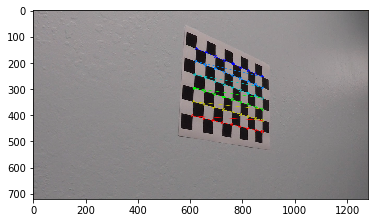

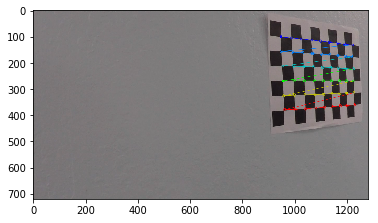

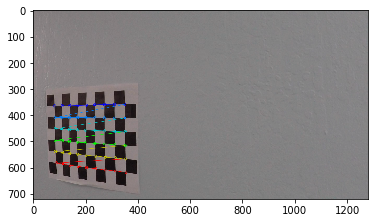

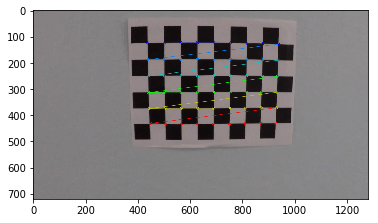

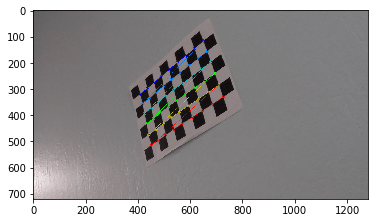

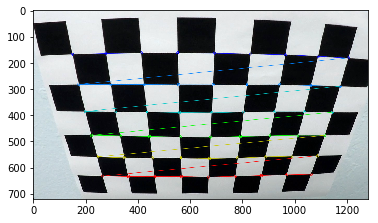

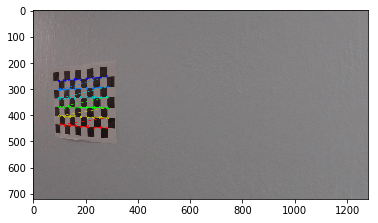

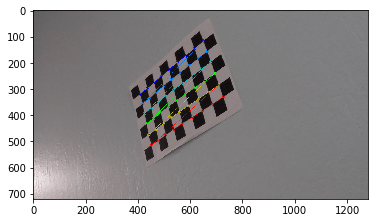

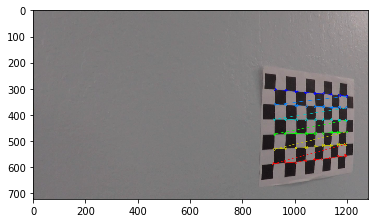

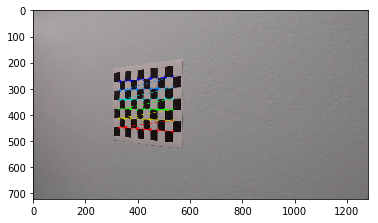

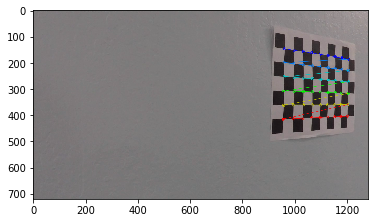

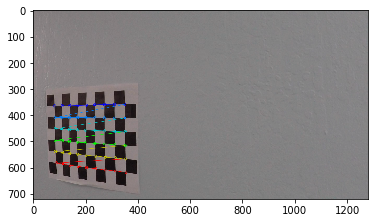

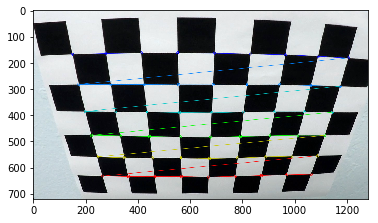

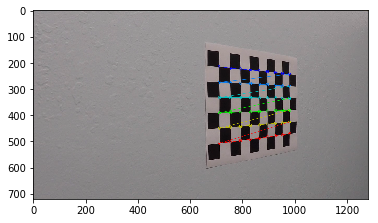

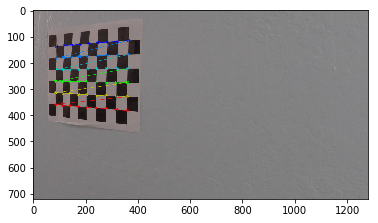

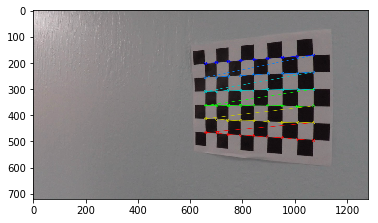

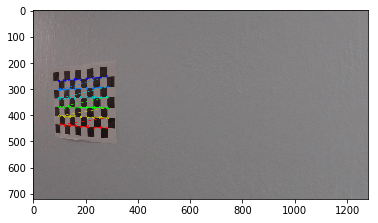

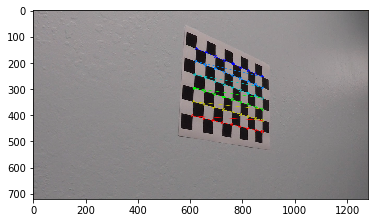

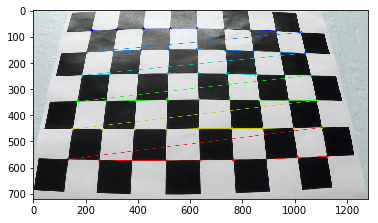

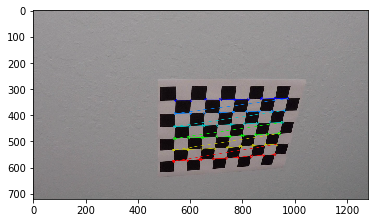

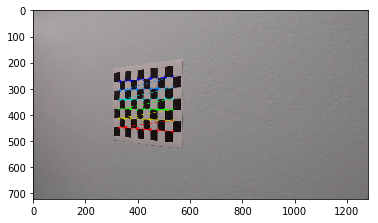

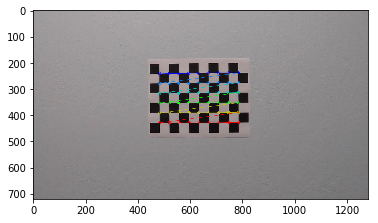

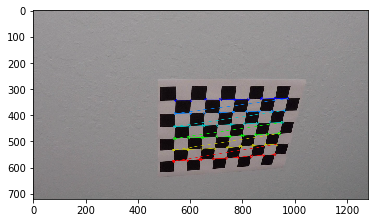

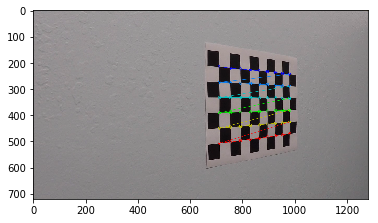

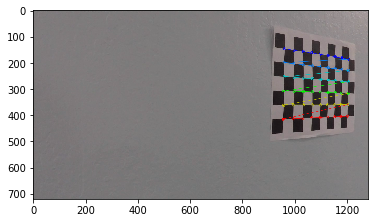

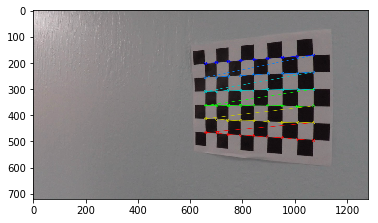

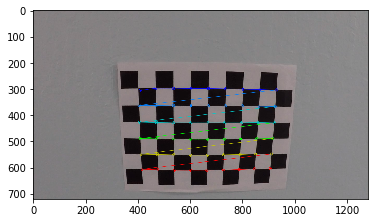

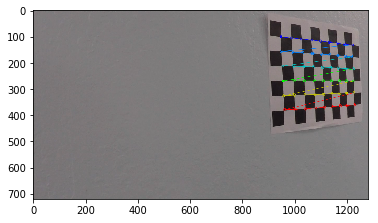

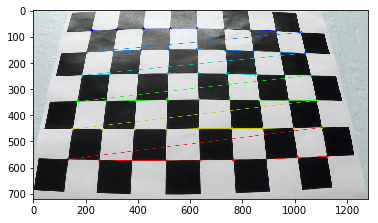

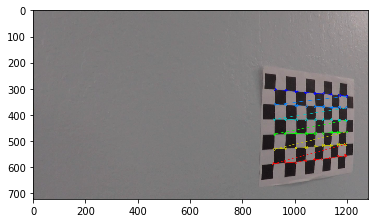

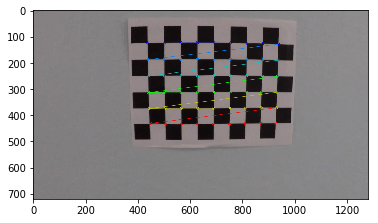

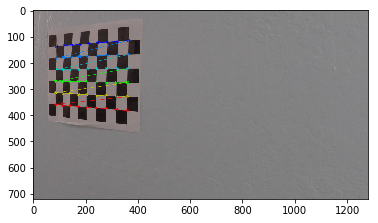

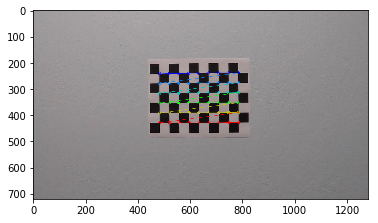

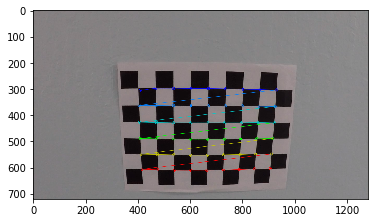

In [2]:
file_name = 'camera_cal'
path = os.listdir(file_name)

# prepare object points
(nx, ny) = (9, 6)
img_points = []
obj_points = []
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

for name in path:
    # Make a list of calibration images
    img = cv2.imread(file_name + '/' + name)
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    # If found, draw corners
    if ret == True:
        # Draw and display the corners
        # append the points set
        img_points.append(corners)
        obj_points.append(objp)
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.imshow(img)
        plt.show()


## Calibrate Camera

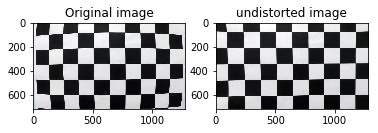

In [3]:
img_size = (gray.shape[1],gray.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, img_size,None,None)
def cal_undistort(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

img = cv2.imread(file_name + '/' + 'calibration1.jpg')
undistorted= cal_undistort(img, mtx, dist)
plt.figure()
plt.subplot(1,2,1)
plt.title('Original image')
plt.imshow(img)
plt.subplot(1,2,2)
plt.title('undistorted image')
plt.imshow(undistorted)
plt.savefig('Temp/one.png')
plt.show()


## Test Calibration

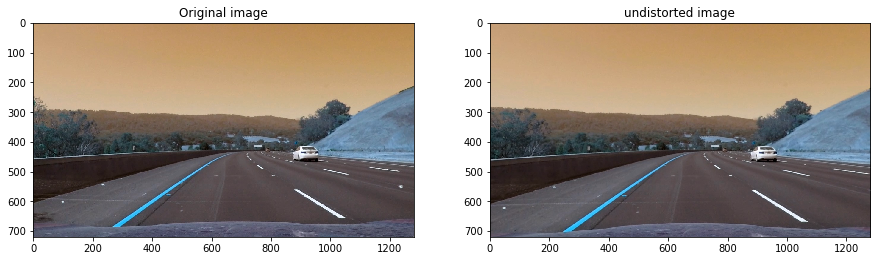

In [4]:
img = cv2.imread('test_images/test3.jpg')
undist = cal_undistort(img, mtx, dist)
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.title('Original image')
plt.imshow(img)
plt.subplot(1,2,2)
plt.title('undistorted image')
plt.imshow(undist)
plt.savefig('Temp/two.png')
plt.show()

## Define necessary function (multi threshold)


In [5]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F,1,0,ksize = sobel_kernel))
    scaled_sobel = np.uint8(255*sobelx/np.max(sobelx))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

def rgb_thresh(img, channel = 'r', thresh = (0,255)):
    if channel == 'b':
        ch = 0
    elif channel == 'g':
        ch = 1
    else:
        ch = 2
    channel_img = img[:,:,ch]
    rgb_binary = np.zeros_like(channel_img)
    rgb_binary[(channel_img >= thresh[0]) & (channel_img <= thresh[1])] = 1
    return rgb_binary


def lab_thresh(img, channel = 'l',thresh=(0, 255)):
    lab = cv2.cvtColor(img,cv2.COLOR_BGR2Lab)
    if channel == 'l':
        ch = 0
    elif channel == 'a':
        ch = 1
    else:
        ch = 2
    channel_img = lab[:,:,ch]
    lab_binary = np.zeros_like(channel_img)
    lab_binary[(channel_img >= thresh[0]) & (channel_img <= thresh[1])] = 1
    return lab_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize = sobel_kernel))
    sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize = sobel_kernel))
    abs_Sobel = np.sqrt(sobelx**2+sobely**2)
    scale_factor = np.max(abs_Sobel)/255 
    scaled_sobel = (abs_Sobel/scale_factor).astype(np.uint8)
    # Apply threshold
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
   # Calculate gradient magnitude
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize = sobel_kernel))
    sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize = sobel_kernel))
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    # Apply threshold
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return dir_binary

def combine_rgb_thresh(img, r = (0,255), g = (0,255), b = (0,255)):
    rgb = cv2.GaussianBlur(img,(5,5),2.0)
    channel_r = rgb_thresh(rgb,'r',r)
    channel_g = rgb_thresh(rgb,'g',g)    
    channel_b = rgb_thresh(rgb,'b',b)
    rgb_binary = np.zeros_like(channel_r)
    rgb_binary[(channel_r == 1)&(channel_g == 1)&(channel_b == 1)] = 1
    return rgb_binary

def combine_lab_thresh(img, l = (0,255), a = (0,255), b = (0,255)):
    lab = cv2.GaussianBlur(img,(5,5),2.0)
    channel_l = lab_thresh(lab,'l',l)
    channel_a = lab_thresh(lab,'a',a)    
    channel_b = lab_thresh(lab,'b',b)
    lab_binary = np.zeros_like(channel_l)
    lab_binary[(channel_l == 1)&(channel_a == 1)&(channel_b == 1)] = 1
    return lab_binary

def combine_all_thresh(img,lab_l=(0,255),lab_a=(0,255),lab_b=(0,255),rgb_r=(0,255),rgb_g=(0,255),rgb_b=(0,255)):
    lab_binary = combine_lab_thresh(img, lab_l, lab_a, lab_b)
    rgb_binary = combine_rgb_thresh(img, rgb_r, rgb_g, rgb_b)
    color_binary = np.zeros_like(lab_binary)
    color_binary[(lab_binary==1)|(rgb_binary==1)]=1
    return color_binary

# Method I: Use build-in function

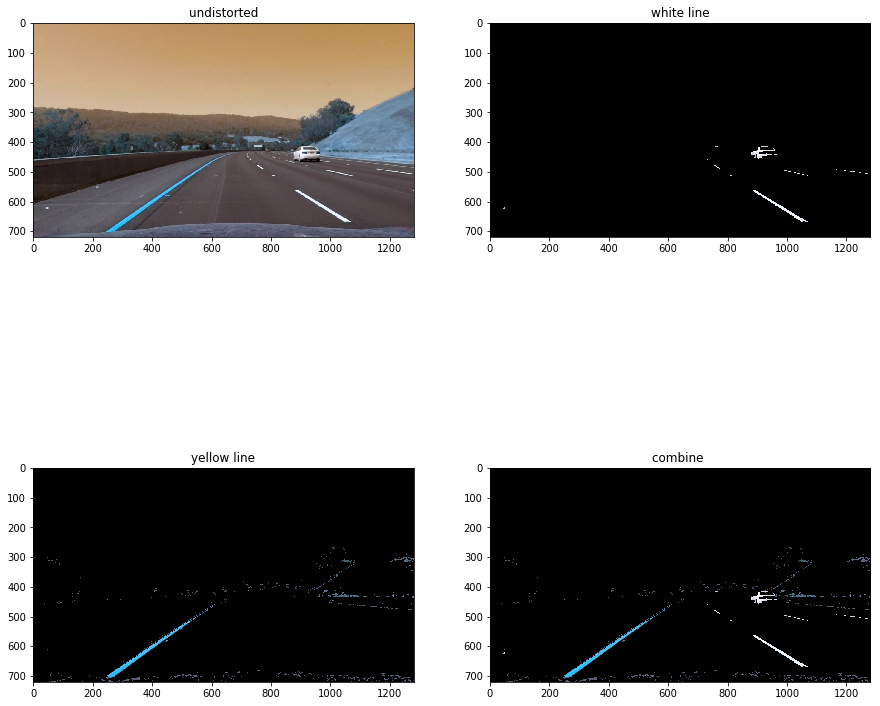

In [6]:
mask_white = cv2.inRange(undist, (180, 180, 210), (255, 255, 255))
## slice the white
imask = mask_white>0
white = np.zeros_like(undist, np.uint8)
white[imask] = undist[imask]
# BGR
mask_yellow = cv2.inRange(undist, (20, 90, 100), (90, 255, 255))
imask = mask_yellow>0
yellow = np.zeros_like(undist, np.uint8)
yellow[imask] = undist[imask]

mask = cv2.bitwise_or(mask_white, mask_yellow)
target = cv2.bitwise_and(undist,undist, mask=mask)


plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.title('undistorted')
plt.imshow(undist)

plt.subplot(2,2,2)
plt.title('white line')
plt.imshow(white,cmap ='Greys_r')

plt.subplot(2,2,3)
plt.title('yellow line')
plt.imshow(yellow,cmap ='Greys_r')

plt.subplot(2,2,4)
plt.title('combine ')
plt.imshow(target,cmap ='Greys_r')

# Method II: Use pre-defined function

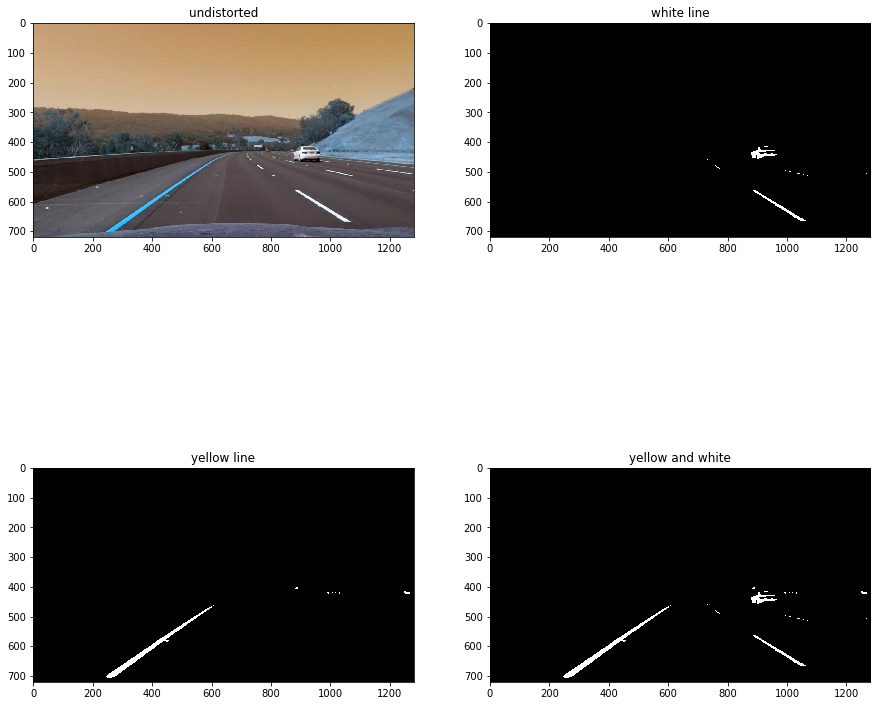

In [7]:
#white_detect = combine_rgb_thresh(undist,r = (180,255),g = (180,255),b = (100,255))
#yellow_detect = combine_rgb_thresh(undist,r = (170,255),g = (90,255),b = (20,90))
#combine_white_yellow = np.zeros_like(white_detect)
#combine_white_yellow[(white_detect == 1) | (yellow_detect == 1)] =1
yellow_detect = combine_lab_thresh(undist, (0,255),  (0,255),  (155,255))
white_detect = combine_rgb_thresh(undist, (177,255),(177,255),(177,255))
combine_white_yellow=combine_all_thresh(undist, (0,255),(0,255),(155,255),(177,255),(177,255),(177,255))


plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.title('undistorted')
plt.imshow(undist)

plt.subplot(2,2,2)
plt.title('white line')
plt.imshow(white_detect,cmap ='Greys_r')

plt.subplot(2,2,3)
plt.title('yellow line')
plt.imshow(yellow_detect,cmap ='Greys_r')

plt.subplot(2,2,4)
plt.title('yellow and white')
plt.imshow(combine_white_yellow,cmap ='Greys_r')

# Undistort and Transform

Text(0.5,1,'warped')

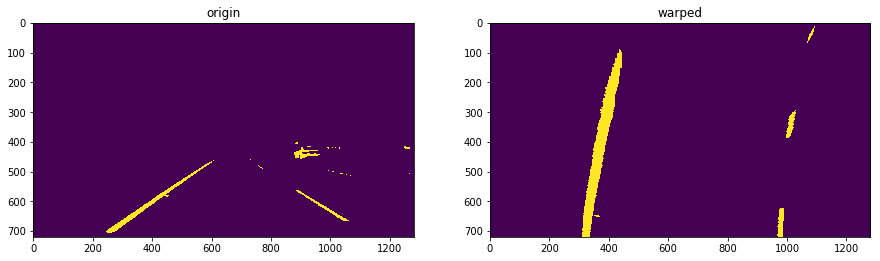

In [8]:
#src = np.float32([[220,690],[500,480],[700,480],[1133,690]])
#src = np.float32([[200,700],[400,400],[800,400],[1200,700]])
src = np.float32([[293,668],[587,458],[703,458],[1028,668]])

img_size = (img.shape[1],img.shape[0])
dst = np.float32([[310,img_size[1]],[310,0],[950,0],[950,img_size[1]]])
#dst = np.float32([[300,750],[300,0],[900,0],[900,750]])

M = cv2.getPerspectiveTransform(src, dst)
warped = cv2.warpPerspective(combine_white_yellow, M, img_size, flags=cv2.INTER_LINEAR)
plt.figure(figsize =(15,15))
plt.subplot(1,2,1)
plt.imshow(combine_white_yellow)
plt.title('origin')

plt.subplot(1,2,2)
plt.imshow(warped)
plt.title('warped')

# Finding the Lines: Sliding Window

In [9]:
def find_lane_pixels(binary_warped,plot=True):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Create an output image to draw on and visualize the result
    output = np.dstack((binary_warped, binary_warped, binary_warped))
    output = 255*(np.uint8(output*255))
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 55

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current  - margin   # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(output,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(output,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        #If found > minpix pixels, recenter next window 
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        ### (`right` or `leftx_current`) on their mean position ###
        pass # Remove this when you add your function

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each with np.polyfit()
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    
    #alc both polynomials using ploty, left_fit and right_fit
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    output[lefty,leftx] = [255, 0, 0]
    output[righty,rightx] = [0, 0, 255]
    
    if plot == True:
        plt.figure(figsize=(15,15))
        plt.imshow(output)
        plt.plot(left_fitx, ploty,color = 'yellow')
        plt.plot(right_fitx, ploty,color = 'yellow')
        plt.xlim(0,1280)
        # No (0,720)
        plt.ylim(720,0)
        
    return left_fit, right_fit, output

def fit_lines_continous(binary_warped, left_fit, right_fit, nwindows=9,plot=True):
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    margin = 80
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & 
                      (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & 
                       (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
# Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
# Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    output = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(output)
    
# Color in left and right line pixels
    output[lefty, leftx] = [255, 0, 0]
    output[righty, rightx] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    if plot==True:
    # Draw the lane onto the warped blank image
        cv2.fillPoly(out_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(out_img, np.int_([right_line_pts]), (0,255, 0))
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    return left_fit, right_fit, output

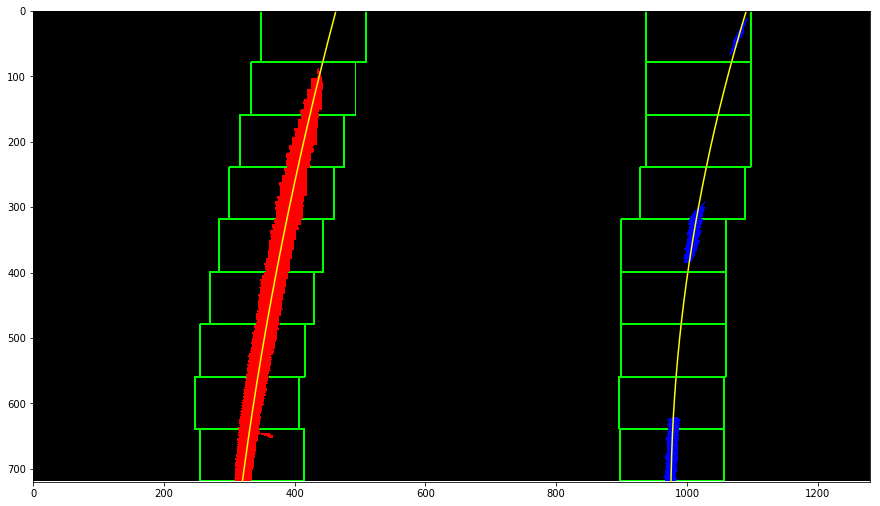

In [10]:
left_fit, right_fit, output = find_lane_pixels(warped)

# Calculate Curvature

In [11]:
def measure_curvature_real(left_fit,right_fit,img_size):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    ploty = np.linspace(0,img_size[0]-1,num = img_size[0])    
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Generate x and y values for plotting
    leftx = left_fit[0]*ploty**2 +left_fit[1]*ploty + left_fit[2]
    rightx = right_fit[0]*ploty**2 +right_fit[1]*ploty + right_fit[2]
    
    # Fit a second order polynomial to pixel positions in each lane line
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    #Implement the calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    xoffset =(left_fit_cr[2] + right_fit_cr[2])/2 - img.shape[1]*xm_per_pix/2
    if xoffset> 0:
        direction = 'left';
    else:
        direction = 'right'
    return left_curverad, right_curverad, xoffset, direction

Minv = cv2.getPerspectiveTransform(dst, src)
def warp_perspective_back(img, warped,img_size,left_fit,right_fit, Minv):

    warp_zero = np.uint8(np.zeros_like(warped))
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    ploty = np.linspace(0,img_size[0]-1,num = img_size[0])
    
    leftx = left_fit[0]*ploty**2 +left_fit[1]*ploty + left_fit[2]
    rightx = right_fit[0]*ploty**2 +right_fit[1]*ploty + right_fit[2]
    
    pts_left = np.array([np.transpose(np.vstack([leftx,ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([rightx,ploty])))])
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts = np.hstack((pts_left,pts_right))
    # pts: array of polygons where each polygon is represented as an array of points.
    # cv2.fillPoly(img, pts, color[, lineType[, shift[, offset]]]) → img
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    cv2.fillPoly(color_warp, np.int_([pts]),(0,255,0))
    newwarp = cv2.warpPerspective(color_warp, Minv,img_size) 
    
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    return result

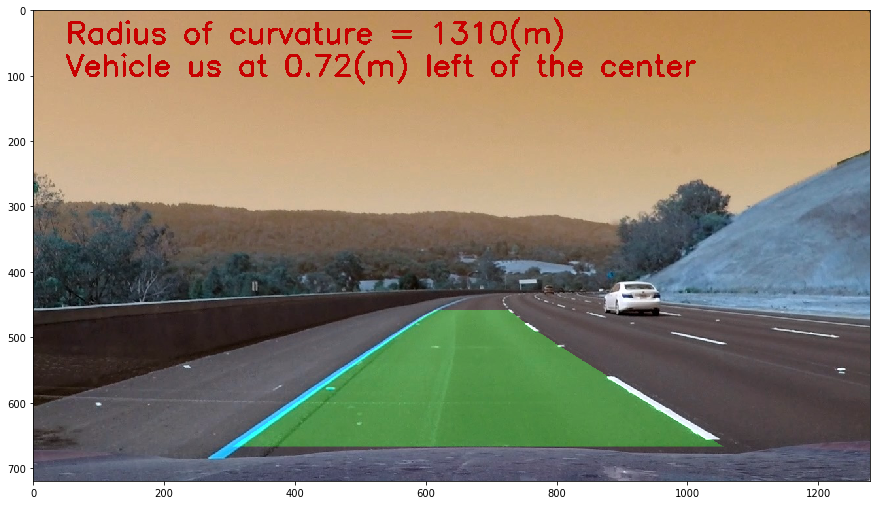

In [12]:
left_curverad, right_curverad,xoffset, direction = measure_curvature_real(left_fit,right_fit,img_size)
curvature = (left_curverad + right_curverad)/2
img = cv2.imread('test_images/test3.jpg')
result = warp_perspective_back(img, warped,img_size, left_fit, right_fit,Minv)

font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(result, 'Radius of curvature = %d(m)' %(curvature),(50,50),font, 1.5, (200,0,0), 3, 3)

cv2.putText(result,('Vehicle us at %1.2f(m) %s of the center' %(xoffset,direction)),(50,100), font, 1.5, (200, 0, 0), 3, 3)

plt.figure(figsize=(15,15))
plt.imshow(result)


In [13]:
def sanity_check(left_fit, right_fit):
    if len(left_fit)<3 or len(right_fit)<3:
        return False
    
    ploty=np.linspace(0, 720, 30)
    leftx=left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
    rightx=right_fit[0]*ploty**2+right_fit[1]*ploty+right_fit[2]
    mean_dist=np.mean(rightx-leftx)
    dmin=np.min(rightx-leftx)
    dmax=np.max(rightx-leftx)
    if mean_dist>=550 and mean_dist<=750:
        status=True
    else:
        return False
    if  dmax-dmin<=80:
        status=True
    else:
        return False
    slope_left=2*left_fit[0]*ploty+left_fit[1] #calualuate the slope of some random selected points and compare them
    slope_right=2*right_fit[0]*ploty+right_fit[1]
    if np.mean(np.abs(slope_left-slope_right))<0.12:
        status=True
    else:
        return False
    return status

In [14]:
def process_img(img):
    global left_fit
    global right_fit
    global last_left_fit
    global last_right_fit
    global counter
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    und=cal_undistort(img, mtx, dist)
    img_shape = (img.shape[1],img.shape[0])
    
    #white_detect = combine_rgb_thresh(und,r = (180,255),g = (180,255),b = (100,255))
    #yellow_detect = combine_rgb_thresh(und,r = (170,255),g = (90,255),b = (20,90))
    #color_binary = np.zeros_like(white_detect)
    #color_binary[(white_detect == 1) | (yellow_detect == 1)] =1
    
    color_binary = combine_all_thresh(und,(0,255),(0,255),(155,255),(177,255),(177,255),(177,255))
    warp=cv2.warpPerspective(color_binary, M, img_shape, flags=cv2.INTER_LINEAR)
    
    if counter == 0:
        left_fit, right_fit,output = find_lane_pixels(warp,False)
    else:
        try:
            left_fit, right_fit,output = fit_lines_continous(warp, left_fit, right_fit, warp,False)
        except TypeError:
            pass

        #left_fit, right_fit = last_left_fit, last_right_fit
    
    # last_left_fit, last_right_fit = left_fit, right_fit
    
    # Status check
    status =sanity_check(left_fit, right_fit)
    
    if sanity_check(left_fit, right_fit)==True:
        last_left_fit, last_right_fit = left_fit, right_fit        
        counter+=1
    else:       
    #Use the last realible fit
        left_fit, right_fit = last_left_fit, last_right_fit
    
    
    left_curverad, right_curverad,xoffset, direction = measure_curvature_real(left_fit,right_fit,img_size)
    curvature = (left_curverad + right_curverad)/2
    result = warp_perspective_back(img, warped,img_size, left_fit, right_fit,Minv)

    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result, 'Radius of curvature = %d(m)' %(curvature),(50,50),font, 1.5, (200,0,0), 3, 3)

    cv2.putText(result,('Vehicle is %1.2f(m) %s of the center' %(np.abs(xoffset),direction)),(50,100), font, 1.5, (200, 0, 0), 3, 3)
    return result

In [15]:
counter = 0
left_fit,right_fit=None,None
last_left_fit,last_right_fit=None, None

video_output = 'project_video_result.mp4' 
clip2 = VideoFileClip('Video/project_video.mp4') 
video_clip = clip2.fl_image(process_img)#.subclip(23,25) 
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing video project_video_result.mp4


100%|█████████▉| 1260/1261 [04:32<00:00,  4.62it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result.mp4 

CPU times: user 2min 23s, sys: 2.44 s, total: 2min 25s
Wall time: 4min 35s


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))